# Diffusion Model in Pytorch to generate cosmological maps

Download images from the [CAMELS Multifield dataset](https://camels-multifield-dataset.readthedocs.io/en/latest/access.html).

In this example we make use of 15k maps of the total mass field at $z=0$ from the LH SIMBA dataset: `Maps_Mtot_SIMBA_LH_z=0.00.npy`


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)
- Diffusion in astrophysical maps, from [Mudur & Finkbeiner 2022](https://github.com/nmudur/diffusion-models-astrophysical-fields-mlps)
- Annotated diffusion https://huggingface.co/blog/annotated-diffusion

## TO DO

- Apply data transform, not used yet
- Use AMP scaler


(15000, 256, 256)


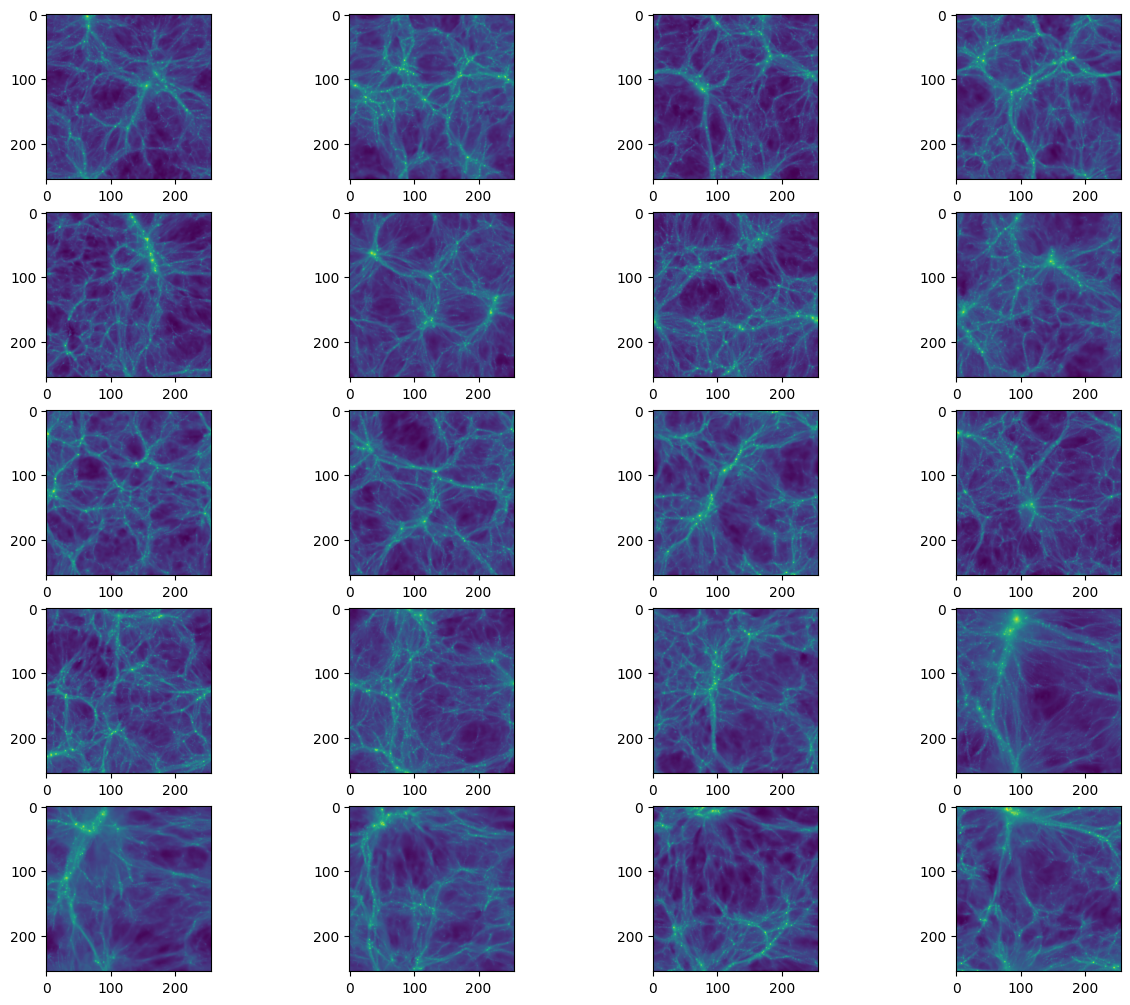

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os

if 

def show_images(data, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples//cols + 1, cols, i + 1)
        plt.imshow(img)

# name of the file
#fmaps = 'CAMELS_data/Maps_Mtot_SIMBA_CV_z=0.00.npy'
fmaps = 'CAMELS_data/Maps_Mtot_SIMBA_LH_z=0.00.npy'

# read the data
dataset = np.load(fmaps)

print(dataset.shape)

# Transform to logarithmic mapping and normalize images
dataset = np.log10(dataset)
dataset = (dataset - dataset.min())/(dataset.max() - dataset.min())

show_images(dataset)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect. 

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [2]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [3]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 256
BATCH_SIZE = 32

def load_transformed_dataset(dataset, set_type="train"):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    #train = torchvision.datasets.StanfordCars(root=".", download=True, transform=data_transform)

    #test = torchvision.datasets.StanfordCars(root=".", download=True, transform=data_transform, split='test')
    
    train = dataset[:350]
    test = dataset[350:]
    #train = dataset[:3]
    #test = dataset[3:50]
    
    return torch.utils.data.ConcatDataset([train, test])
    #return DataLoaderdataset[:20]

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        #transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, 0, :, :] 
    #plt.imshow(reverse_transforms(image))
    plt.imshow(image)

data = load_transformed_dataset(dataset)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

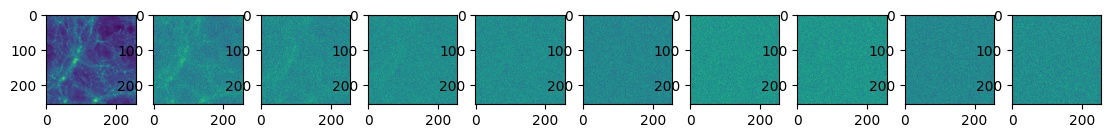

In [4]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T//num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx//stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [5]:
from net import SimpleUnet

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62437601


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [6]:
criterion = torch.nn.MSELoss()

def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return criterion(noise_pred, noise)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [7]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    num_images = 4
    imgbtch = torch.randn((num_images, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    stepsize = int(T//num_images)

    """
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i//stepsize+1)
            show_tensor_image(img.detach().cpu())
    #"""
    for i in range(num_images):
        t = torch.full((1,), 0, device=device, dtype=torch.long)
        img = sample_timestep(imgbtch[i:i+1], t)
        plt.subplot(1, num_images, i+1)
        show_tensor_image(img.detach().cpu())
    plt.show()            

## Training

In [8]:
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import time
from tqdm import tqdm

lr_max = 1.e-3
lr_min = 1.e-6
weight_decay = 1.e-7

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: ",device)
model.to(device)

namerun = "test"
bestmodelname = "models/"+namerun
print("Model:", namerun)
if os.path.exists(bestmodelname):
    print("Loading previous model")
    print(namerun)
    state_dict = torch.load(bestmodelname, map_location=device)
    model.load_state_dict(state_dict)
else:
    print("No previous model to be loaded")

optimizer = Adam(model.parameters(), lr=lr_max, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, cycle_momentum=False)

epochs = 40
valid_loss_min = 1.e10

tim = time.localtime()
strdate = "{:02d}-{:02d}_{:02d}:{:02d}".format(tim.tm_mday, tim.tm_mon, tim.tm_hour, tim.tm_min)
logdir = "runs/"+namerun+"_"+strdate
writer = SummaryWriter(log_dir=logdir)

for epoch in range(epochs):
    
    pbar = tqdm(dataloader, total=len(dataloader), position=0, leave=True, desc=f"Training")
    
    train_loss = 0.
    valid_loss = 0.
    
    for step, batch in enumerate(pbar):
        batch = batch.unsqueeze(1)
        optimizer.zero_grad(set_to_none=True)

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch, t)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
            
        writer.add_scalar("Training loss per gradient step", loss, epoch*len(dataloader) + step)
        
        train_loss += loss
        
    train_loss /= len(dataloader.sampler)
    train_loss = train_loss.item()
        
    writer.add_scalar("Training loss", train_loss, epoch)
    print(f"Epoch {epoch} | step {step:03d} Loss: {train_loss} ")
    sample_plot_image()
    
    if train_loss <= valid_loss_min:
        valid_loss_min = train_loss
        torch.save(model.state_dict(), bestmodelname)

Device:  cuda
Model: test
Loading previous model
test


Training:  11%|███████████▌                                                                                            | 52/468 [02:27<19:39,  2.84s/it]

KeyboardInterrupt

